In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from nbdev.showdoc import *
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Curvature of Loss Landscapes

# Load Data

In [ ]:
paths = {
    'good minima': '~/data/loss_landscapes/good-epoch.npy',
    # 'bad minima': '~/data/loss_landscapes/bad-epoch-0.5.npy',
    # 'bad minima': '~/data/loss_landscapes/bad-minima-JR-0.2.npy',
    'bad minima': '~/data/loss_landscapes/bad-minima-JR-0.75.npy',
}

In [ ]:
import pandas as pd
import numpy as np

landscape_data = {}

for key, path in paths.items():
    file_path = os.path.expanduser(path)
    data = np.load(file_path)
    df = pd.DataFrame(data)
    landscape_data[key] = df


In [ ]:
for key, df in landscape_data.items():
    num_cols = df.shape[1] - 4
    new_cols = list(range(num_cols)) + ['loss', 'radii', 'epoch', 'distance to minima']
    df.rename(columns=dict(zip(df.columns, new_cols)), inplace=True)

In [ ]:
landscape_data['good minima']

,0,1,2,3,4,5,6,7,8,9,...,405038,405039,405040,405041,405042,405043,loss,radii,epoch,distance to minima
0,0.280376,0.280376,0.280377,0.280376,0.280377,0.280376,0.280377,0.280378,0.280378,0.280376,...,-0.041525,0.388240,-0.580694,-0.373845,0.774116,0.426215,0.483090,0.19,0.0,26660.245509
1,0.050975,0.050974,0.050976,0.050971,0.050976,0.050972,0.050975,0.050972,0.050971,0.050975,...,-0.053193,-0.032333,-0.158201,-0.373433,0.972045,-0.163731,0.473100,0.24,0.0,27515.750534
2,0.040648,0.040644,0.040648,0.040651,0.040644,0.040655,0.040647,0.040648,0.040647,0.040652,...,0.076687,0.020562,-0.377104,-0.531000,0.813464,0.473623,0.425239,0.48,0.0,26368.748987
3,0.035914,0.035910,0.035910,0.035908,0.035910,0.035911,0.035910,0.035913,0.035914,0.035910,...,-0.224642,0.083340,-0.268150,-0.179373,0.803069,0.332447,0.436793,0.54,0.0,24946.402410
4,0.043997,0.043997,0.043997,0.043997,0.043997,0.043997,0.043997,0.043997,0.043997,0.043997,...,-0.057871,-0.163761,-0.283982,-0.567516,1.094714,0.262321,0.497975,0.03,0.0,27381.424517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,0.026591,0.026588,0.026592,0.026592,0.026589,0.026588,0.026590,0.026592,0.026591,0.026589,...,-0.065077,-0.183786,-0.194390,-0.472732,0.679411,0.180270,0.391202,0.85,0.0,25080.359758
1200,0.033630,0.033632,0.033642,0.033642,0.033636,0.033640,0.033638,0.033642,0.033639,0.033632,...,-0.061085,0.002706,-0.667900,-0.439733,0.958513,0.180198,0.413318,0.77,0.0,32506.364433
1201,0.050860,0.050865,0.050864,0.050859,0.050854,0.050867,0.050860,0.050863,0.050867,0.050854,...,-0.233403,0.169382,-0.238043,-0.064483,0.444113,0.215008,0.540342,0.48,0.0,28511.584486
1202,0.027232,0.027235,0.027236,0.027231,0.027227,0.027236,0.027233,0.027230,0.027231,0.027227,...,0.045118,-0.103158,-0.369154,-0.160101,0.506007,0.295186,0.543877,0.34,0.0,27646.548200


In [ ]:
good_points = landscape_data['good minima'].iloc[:, :-3].values
bad_points = landscape_data['bad minima'].iloc[:, :-3].values

In [ ]:
landscape_data['good minima']['loss'].values

array([0.48309012, 0.47309988, 0.42523935, ..., 0.54034183, 0.54387739,
       0.37704424])

In [ ]:
index_good = landscape_data['good minima']['distance to minima'].idxmin()
index_bad = landscape_data['bad minima']['distance to minima'].idxmin()

print("Index of the point with shortest distance to minima in 'good minima' dataframe:", index_good)
print("Index of the point with shortest distance to minima in 'bad minima' dataframe:", index_bad)


Index of the point with shortest distance to minima in 'good minima' dataframe: 637
Index of the point with shortest distance to minima in 'bad minima' dataframe: 1144


In [ ]:
landscape_data['good minima'].iloc[index_good, :]

0                         0.018906
1                         0.018913
2                         0.018914
3                         0.018923
4                         0.018918
                          ...     
405043                    0.229320
loss                      0.548706
radii                     0.550000
epoch                     0.000000
distance to minima    22582.217163
Name: 637, Length: 405048, dtype: float64

In [ ]:
index_good = landscape_data['good minima']['radii'].idxmin()
index_bad = landscape_data['bad minima']['radii'].idxmin()

print("Index of the point with shortest distance to minima in 'good minima' dataframe:", index_good)
print("Index of the point with shortest distance to minima in 'bad minima' dataframe:", index_bad)


Index of the point with shortest distance to minima in 'good minima' dataframe: 295
Index of the point with shortest distance to minima in 'bad minima' dataframe: 85


In [ ]:
landscape_data['good minima'].iloc[index_good, :]

0                         0.061493
1                         0.061493
2                         0.061493
3                         0.061493
4                         0.061493
                          ...     
405043                   -0.244779
loss                      0.442232
radii                     0.010000
epoch                     0.000000
distance to minima    25058.398632
Name: 295, Length: 405048, dtype: float64

# Parameters

In [ ]:
t = 10
k = 5

# Getting a Graph

In [ ]:
show_doc(get_adaptive_graph)

---

### get_adaptive_graph

>      get_adaptive_graph (X, k=10, alpha=0)

In [ ]:
from diffusion_curvature.core import get_adaptive_graph
good_graph = get_adaptive_graph(good_points, k=k)

2024-01-19 14:22:46,584:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
bad_graph = get_adaptive_graph(bad_points, k=k)

2024-01-19 14:22:49,872:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


# Graph Distances

We use HeatGeo for graph distances. This algorithm has a few parameters of its own to tweak; however, you can verify that the graph (and distances) make sense by visualizing the resulting embedding.

In [ ]:
from heatgeo.embedding import HeatGeo
emb_op = HeatGeo(knn=k)
emb = emb_op.fit_transform(good_points)
D_good = emb_op.dist

Using s_gd2 for MDS. None


We can sanity check these distances both through the quality of the embedding, and the relative distribution of the curvature therein.

<matplotlib.colorbar.Colorbar>

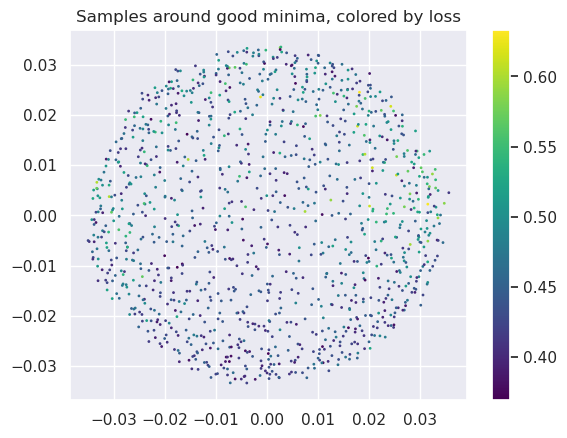

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c = landscape_data['good minima']['loss'].values,s=1, cmap='viridis')
plt.title('Samples around good minima, colored by loss')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

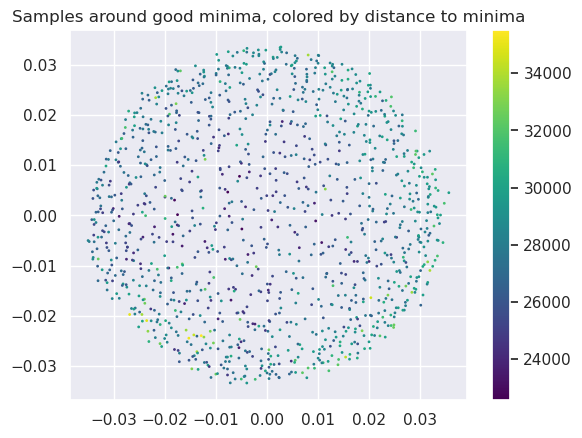

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c = landscape_data['good minima']['distance to minima'].values,s=1, cmap='viridis')
plt.title('Samples around good minima, colored by distance to minima')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

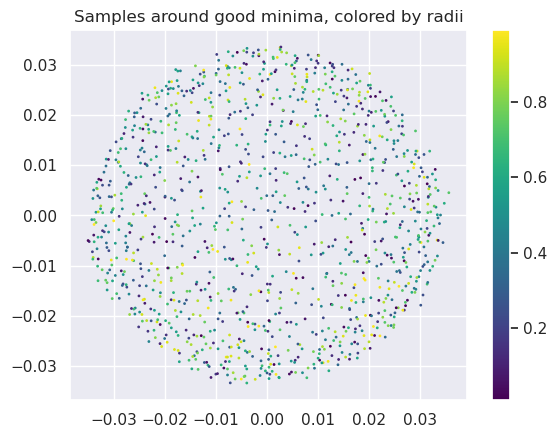

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c = landscape_data['good minima']['radii'].values,s=1, cmap='viridis')
plt.title('Samples around good minima, colored by radii')
plt.colorbar()

The distance to minima and radii give quite different values. Which one should be trusted?

In [ ]:
from heatgeo.embedding import HeatGeo
emb_op_bad = HeatGeo(knn=k)
emb_bad = emb_op_bad.fit_transform(bad_points)
D_bad = emb_op_bad.dist

Using s_gd2 for MDS. None


We can sanity check these distances both through the quality of the embedding, and the relative distribution of the curvature therein.

Text(0.5, 1.0, 'Bad minima')

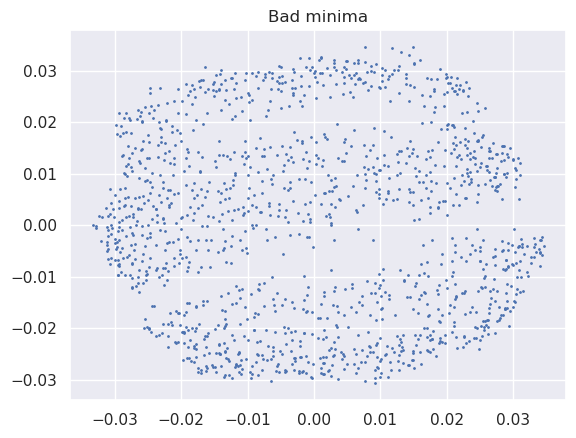

In [ ]:
plt.scatter(emb_bad[:,0], emb_bad[:,1], s=1, cmap='viridis')
plt.title('Bad minima')

<matplotlib.colorbar.Colorbar>

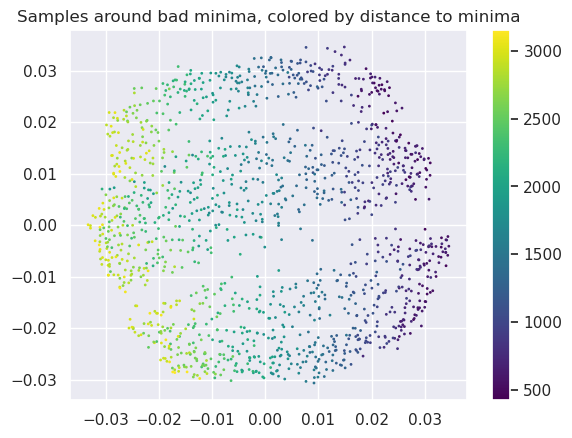

In [ ]:
plt.scatter(emb_bad[:,0], emb_bad[:,1], c = landscape_data['bad minima']['distance to minima'].values,s=1, cmap='viridis')
plt.title('Samples around bad minima, colored by distance to minima')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

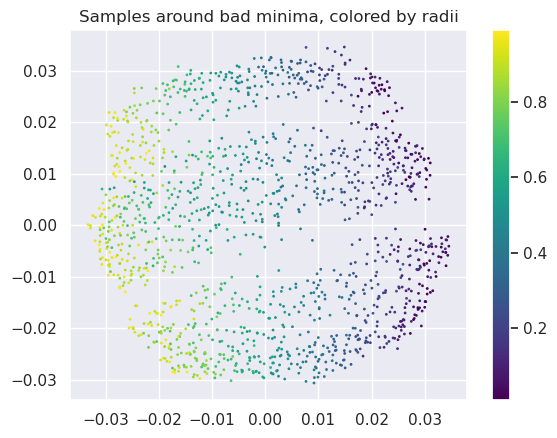

In [ ]:
plt.scatter(emb_bad[:,0], emb_bad[:,1], c = landscape_data['bad minima']['radii'].values,s=1, cmap='viridis')
plt.title('Samples around bad minima, colored by radii')
plt.colorbar()

Calculating PHATE...
  Running PHATE on 1430 observations and 405045 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


    Calculated PCA in 33.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.15 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 33.25 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.26 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.94 seconds.
Calculated PHATE in 34.61 seconds.


<Axes: >

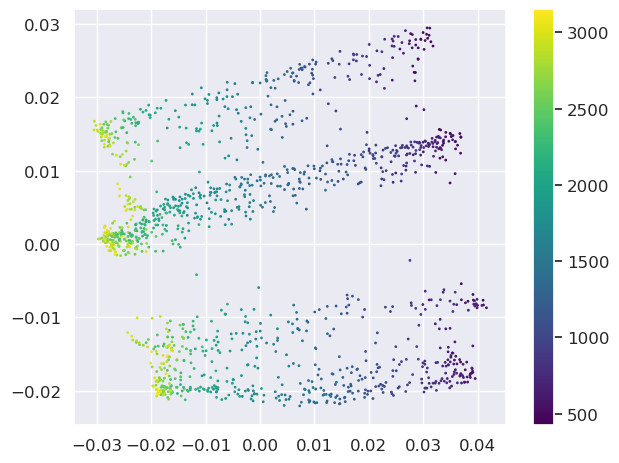

In [ ]:
import phate
phate_op = phate.PHATE(knn=15)
phate_emb = phate_op.fit_transform(bad_points)
phate.plot.scatter2d(phate_emb, c = landscape_data['bad minima']['distance to minima'].values,s=1, cmap='viridis')

# Curvature

Here are the parameters for Wasserstein.
Remember to pass in the precomputed distance matrix.

In [ ]:
from diffusion_curvature.core import DiffusionCurvature
show_doc(DiffusionCurvature)

---

### DiffusionCurvature

>      DiffusionCurvature
>                          (diffusion_type:Literal['diffusionmatrix','heatkernel
>                          ']='diffusion matrix', laziness_method:Literal['Wasse
>                          rstein','Entropic','Laziness']='Entropic', flattening
>                          _method:Literal['Neural','Fixed','MeanFixed']='Fixed'
>                          , comparison_method:Literal['Ollivier','Subtraction']
>                          ='Subtraction', graph_former=<function
>                          get_adaptive_graph>, dimest=None,
>                          points_per_cluster=None,
>                          comparison_space_size_factor=1, use_grid=False,
>                          max_flattening_epochs=50, aperture=20, smoothing=1, c
>                          omparison_space_file='../data/entropies_averaged.h5',
>                          verbose=False)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| diffusion_type | Literal | diffusion matrix | Either ['diffusion matrix','heat kernel'] |
| laziness_method | Literal | Entropic | Either ['Wasserstein','Entropic', 'Laziness'] |
| flattening_method | Literal | Fixed | Either ['Neural', 'Fixed', 'Mean Fixed'] |
| comparison_method | Literal | Subtraction | Either ['Ollivier', 'Subtraction'] |
| graph_former | function | get_adaptive_graph |  |
| dimest | NoneType | None | Dimension estimator to use. If none, defaults to kNN. |
| points_per_cluster | NoneType | None | Number of points to use in each cluster when constructing comparison spaces. Each comparison space takes about 20sec to construct, and has different sampling and dimension. If 1, constructs a different comparison space for each point; if None, constructs just one comparison space. |
| comparison_space_size_factor | int | 1 | Number of points in comparison space is the number of points in the original space divided by this factor. |
| use_grid | bool | False | If True, uses a grid of points as the comparison space. If False, uses a random sample of points. |
| max_flattening_epochs | int | 50 |  |
| aperture | int | 20 | if using Laziness flattening, this controls the size of neighborhood over which the return probability is averaged. |
| smoothing | int | 1 |  |
| comparison_space_file | str | ../data/entropies_averaged.h5 |  |
| verbose | bool | False |  |

## Curvature of Good Samples

### Wasserstein

In [ ]:
from diffusion_curvature.core import DiffusionCurvature
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    )
ks_good_unsigned_wass = 1/DC.unsigned_curvature(good_graph, t=t, D = D_good)

<matplotlib.colorbar.Colorbar>

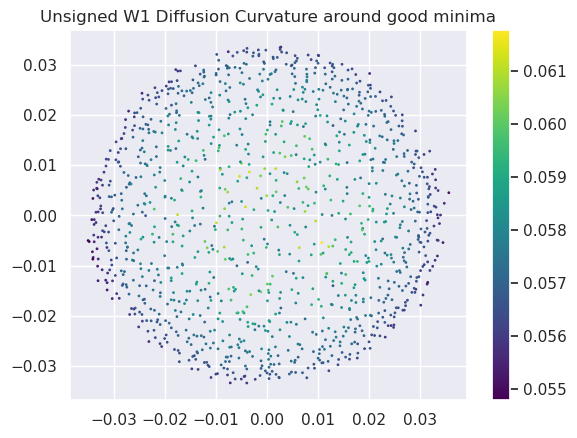

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c = ks_good_unsigned_wass, s=1, cmap='viridis')
plt.title('Unsigned W1 Diffusion Curvature around good minima')
plt.colorbar()

In [ ]:
from diffusion_curvature.core import DiffusionCurvature
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    )
ks_good_unsigned_entropy = 1/DC.unsigned_curvature(good_graph, t=t)

<matplotlib.colorbar.Colorbar>

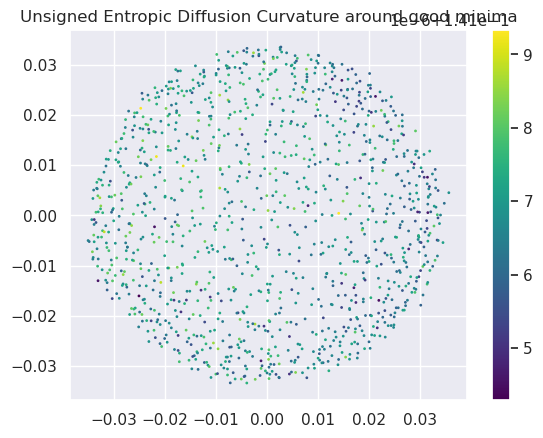

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c = ks_good_unsigned_entropy, s=1, cmap='viridis')
plt.title('Unsigned Entropic Diffusion Curvature around good minima')
plt.colorbar()

In [ ]:
max(ks_good_unsigned_entropy)

Array(0.14100933, dtype=float32)

In [ ]:
min(ks_good_unsigned_entropy)

Array(0.1410043, dtype=float32)

## Curvature of Bad Samples

In [ ]:
from diffusion_curvature.core import DiffusionCurvature
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    )
ks_bad_unsigned_wass = 1/DC.unsigned_curvature(bad_graph, t=t, D = D_bad)

<matplotlib.colorbar.Colorbar>

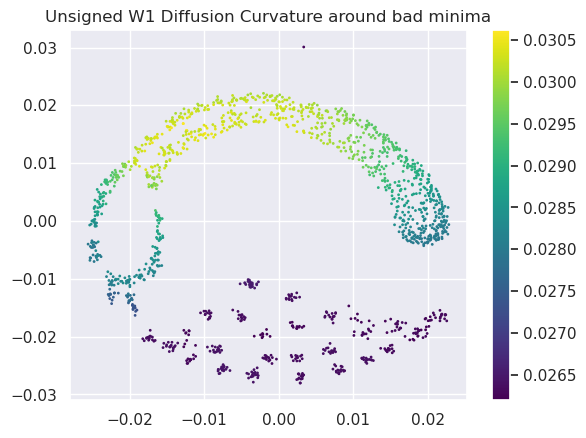

In [ ]:
plt.scatter(emb_bad[:,0], emb_bad[:,1], c = ks_bad_unsigned_wass, s=1, cmap='viridis')
plt.title('Unsigned W1 Diffusion Curvature around bad minima')
plt.colorbar()

In [ ]:
from diffusion_curvature.core import DiffusionCurvature
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    )
ks_bad_unsigned_entropy = 1/DC.unsigned_curvature(bad_graph, t=t)

<matplotlib.colorbar.Colorbar>

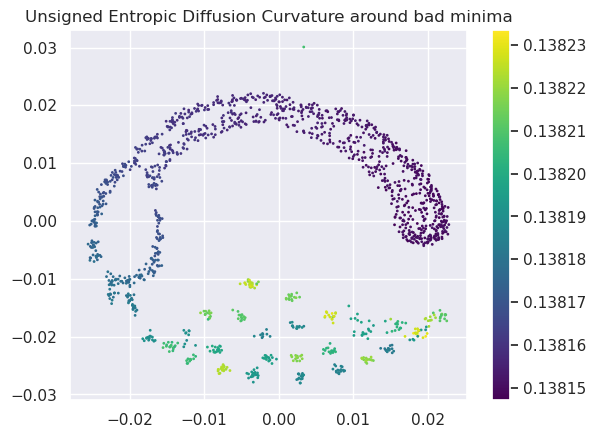

In [ ]:
plt.scatter(emb_bad[:,0], emb_bad[:,1], c = ks_bad_unsigned_entropy, s=1, cmap='viridis')
plt.title('Unsigned Entropic Diffusion Curvature around bad minima')
plt.colorbar()

In [ ]:
max(ks_bad_unsigned_entropy)

Array(0.13823348, dtype=float32)

In [ ]:
min(ks_bad_unsigned_entropy)

Array(0.13814718, dtype=float32)

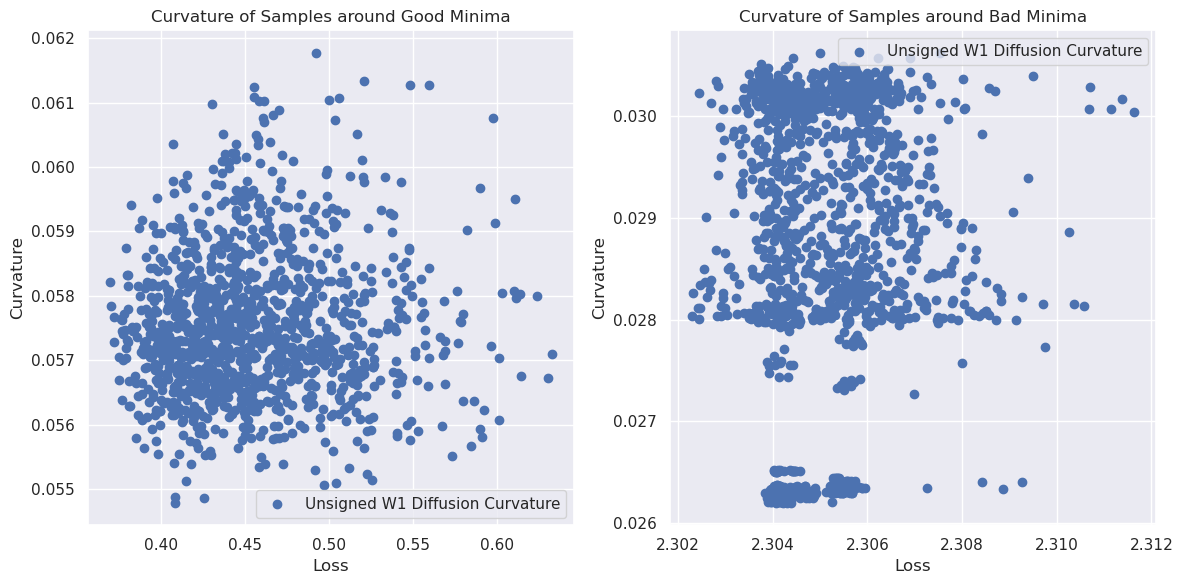

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot curvature versus loss for good minima
ax1.scatter(landscape_data['good minima']['loss'], ks_good_unsigned_wass, label='Unsigned W1 Diffusion Curvature')
# ax1.scatter(landscape_data['good minima']['loss'], ks_good_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax1.set_xlabel('Loss')
ax1.set_ylabel('Curvature')
ax1.set_title('Curvature of Samples around Good Minima')
ax1.legend()

# Plot curvature versus loss for bad minima
ax2.scatter(landscape_data['bad minima']['loss'], ks_bad_unsigned_wass, label='Unsigned W1 Diffusion Curvature')
# ax2.scatter(landscape_data['bad minima']['loss'], ks_bad_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax2.set_xlabel('Loss')
ax2.set_ylabel('Curvature')
ax2.set_title('Curvature of Samples around Bad Minima')
ax2.legend()

plt.tight_layout()
plt.show()


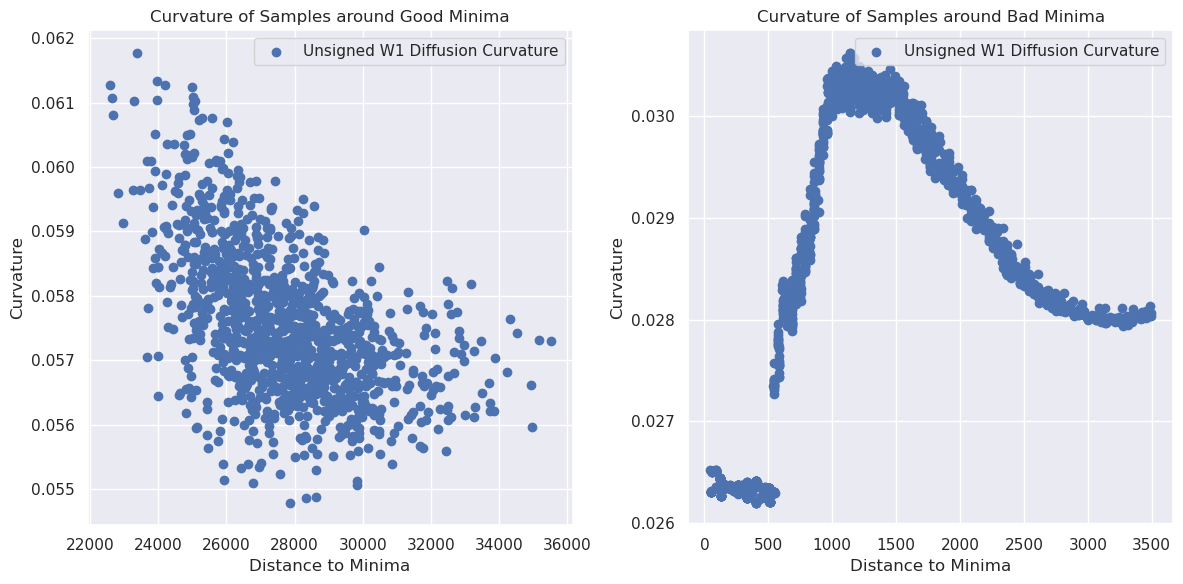

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot curvature versus loss for good minima
ax1.scatter(landscape_data['good minima']['distance to minima'], ks_good_unsigned_wass, label='Unsigned W1 Diffusion Curvature')
# ax1.scatter(landscape_data['good minima']['loss'], ks_good_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax1.set_xlabel('Distance to Minima')
ax1.set_ylabel('Curvature')
ax1.set_title('Curvature of Samples around Good Minima')
ax1.legend()

# Plot curvature versus loss for bad minima
ax2.scatter(landscape_data['bad minima']['distance to minima'], ks_bad_unsigned_wass, label='Unsigned W1 Diffusion Curvature')
# ax2.scatter(landscape_data['bad minima']['loss'], ks_bad_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax2.set_xlabel('Distance to Minima')
ax2.set_ylabel('Curvature')
ax2.set_title('Curvature of Samples around Bad Minima')
ax2.legend()

plt.tight_layout()
plt.show()


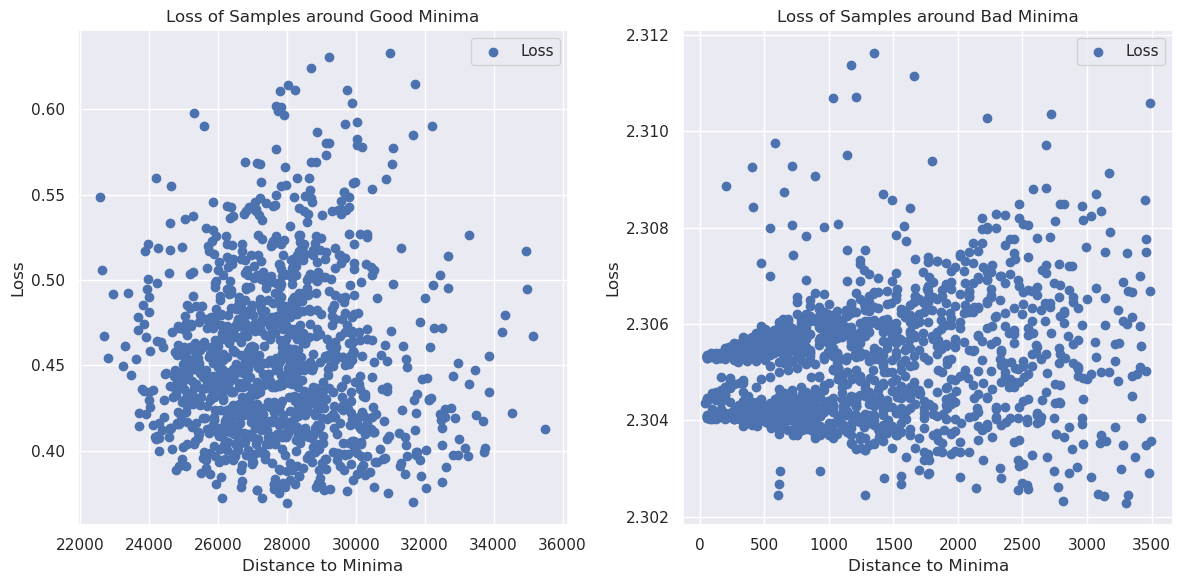

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot curvature versus loss for good minima
ax1.scatter(landscape_data['good minima']['distance to minima'], landscape_data['good minima']['loss'], label='Loss')
# ax1.scatter(landscape_data['good minima']['loss'], ks_good_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax1.set_xlabel('Distance to Minima')
ax1.set_ylabel('Loss')
ax1.set_title('Loss of Samples around Good Minima')
ax1.legend()

# Plot curvature versus loss for bad minima
ax2.scatter(landscape_data['bad minima']['distance to minima'], landscape_data['bad minima']['loss'], label='Loss')
# ax2.scatter(landscape_data['bad minima']['loss'], ks_bad_unsigned_entropy, label='Unsigned Entropic Diffusion Curvature')
ax2.set_xlabel('Distance to Minima')
ax2.set_ylabel('Loss')
ax2.set_title('Loss of Samples around Bad Minima')
ax2.legend()

plt.tight_layout()
plt.show()
